In [1]:
import pystan
import numpy as np

In [2]:
ICU_code = """
functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    deltas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
    deltas[2] = 1 - inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - 0.01;
    return deltas;
  }
}


data {
    int T;
    int YIC[T];
    int spd;
    int begin;
    real N;
    real sgm;
    real gmm;
    vector[10] fEtoIC;
    vector[T] zetat;
    
    
}
transformed data {
    int end = T*7*spd;
    real dt = 1.0/spd;
    int sizemat = ((end-begin)*spd)+ 1;

}
parameters {
    real<lower=0> beta;
    real Tx_pi;
    real Tx_iota;
    
    real Tx_kappa;
    real<lower=0,upper=1> pIC;
    real<lower=1> eta;
    
}
transformed parameters {
    real mat[sizemat,7];
    vector[T] NNI;
    vector[T] NIC;
    vector[T] sizeICs;
    real time = begin;
    real boolK = 0;
    real cumIC = 0;
    
    real<lower=0,upper=1> pi = exp(Tx_pi)/(exp(Tx_pi)+1);
    real<lower=0> iota = exp(Tx_iota)/((exp(Tx_pi)+1)*(exp(Tx_iota)+1));
    real<lower=-1> kappa = exp(Tx_kappa) - 1;
    
    mat[1,1]=time;
    mat[1,2]=(1-pi-iota)*N; 
    mat[1,3]=(iota/4)*N;
    mat[1,4]=(iota/4)*N;
    mat[1,5]=(iota/4)*N;
    mat[1,6]=(iota/4)*N;
    mat[1,7]=pi*N; 
    
    if ( (pi+iota<1)||(beta>=0)||(kappa>=-1)||(pIC<=1)||(pIC>=0)||(eta>=1))
    {
        for (t in 2:sizemat)
        {
            if (((time>=19)&&(time<=28))||((time>=75)&&(time<=92))||
              ((time>=131)&&(time<=140))||((time>=179)&&(time<=196)))
              {
                boolK=1;
              }
            else {boolK=0;}
            mat[t,2] = mat[t-1,2] - dt*beta*(boolK*kappa+1)*mat[t-1,2]*((mat[t-1,5]+mat[t-1,6])/N);
            mat[t,3] = mat[t-1,3] + dt*beta*(boolK*kappa+1)*mat[t-1,2]*((mat[t-1,5]+mat[t-1,6])/N) - dt*sgm*mat[t-1,3];
            mat[t,4] = mat[t-1,4] + dt*sgm*mat[t-1,3] - dt*sgm*mat[t-1,4];
            mat[t,5] = mat[t-1,5] + dt*sgm*mat[t-1,4] - dt*gmm*mat[t-1,5];
            mat[t,6] = mat[t-1,6] + dt*gmm*mat[t-1,5] - dt*gmm*mat[t-1,6];
            mat[t,7] = mat[t-1,7] + dt*gmm*mat[t-1,7];
            time = begin + (t-1)*dt;
            mat[t,1] = time;
        }

        for (s in 1:T)
        {
            NNI[s] = mat[s*7*spd,2] - mat[(s+1)*7*spd,2];
        }

        for (s in 1:T)
        {
            cumIC=0;
            
            for (r in 1:min(s,10))
            {
              cumIC += NNI[s-r+1]*fEtoIC[r];  
            }
            NIC[s] = cumIC*zetat[s]*pIC;    
        }  
        sizeICs = NIC/(eta-1);
    }

}
model {


    if( (pi+iota>=1)||(beta<=0)||(kappa<=-1)||(pIC>=1)||(pIC<=0)||(eta<=1))
    {
        target += negative_infinity();
    }
    else
    {
        target += normal_lpdf(beta|0.0,1.0);
        
        target += beta_lpdf(pi|37.5,62.5) + uniform_lpdf(iota|0.0, 0.1)
                 + ((Tx_pi)-2*log((1+exp(Tx_pi)))) 
                 + ((Tx_iota)-(2*log(1+exp(Tx_iota))+log(1+exp(Tx_pi)))) ;
                 
        target += uniform_lpdf(iota|0., 1e-1)
                + ((Tx_iota)-(2*log(1+exp(Tx_iota))+log(1+exp(Tx_pi))));
                
        target += normal_lpdf(Tx_kappa|0.0,1.0); //std_normal() ?
        
        target += beta_lpdf(pIC|1.0, 2.0);
        
        target += gamma_lpdf(eta|2, 0.1);
        
        for (s in 1:T)
        {
            
            if((sizeICs[s]==0) && (YIC[s]!=0))
            {
                target += negative_infinity();
            }
            else if ((sizeICs[s]==0) && (YIC[s]==0))
            {
                target += 0.0;
            }
            else
            {
                target += neg_binomial_2_lpmf(YIC[s]| NIC[s], sizeICs[s]);// Don't forget to vectorise
            }
        }
        
    }
    
}
"""

In [3]:
sm = pystan.StanModel(model_code=ICU_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6cede0ea01216cd541b642df862a94a2 NOW.


In [17]:
True_params = [0.56, 0.36, 0.0000061, 0.37, 0.00015, 15]

y = np.loadtxt('simYIC.txt', dtype=int)
ICU_data = {'T': int(33), 'YIC': y, 'spd': int(4), 'begin': int(0), 'N': 55268100, 'sgm': 1.0, 'gmm': 0.52,
            'fEtoIC': [0.811443284,0.151835341,0.025467901,
                         0.006698405,0.002425462,0.001061865,
                         0.000524648,0.000282547,0.000162348,
                         0.000098200],
            'zetat': [0.89, 0.89, 0.89, 0.89, 0.89, 0.89,
                         0.83, 0.75, 0.83, 0.89, 0.89, 0.89,
                         0.89, 0.89, 0.89, 0.89, 0.89, 0.89,
                         0.89, 0.89, 0.89, 0.89, 0.89, 0.89,
                         0.89, 0.89, 0.88, 0.8, 0.74, 0.89,
                         0.89, 0.86, 0.74] 
            }

def transform_from_constraint(Utx_pars):
    tx_pi    = np.log( Utx_pars[0]/(1 - Utx_pars[0]) )
    tx_iota  = np.log( Utx_pars[1]/(1 - (Utx_pars[0] + Utx_pars[1]) ) )
    tx_kappa = np.log(Utx_pars[2]+1)
    return tx_pi, tx_iota, tx_kappa
init_pi1, init_iota1, init_kappa1 = transform_from_constraint([0.16,0.0000021,0.1])
init_pi2, init_iota2, init_kappa2 = transform_from_constraint([0.56,0.0000081,0.1])
#init_pi3, init_iota3 = transform_from_constraint([0.71,0.0000051,0.47])
init_chains =[dict(beta=0.46,pi=init_pi1,iota=init_iota1,kappa=init_kappa1,pIC=0.00018,eta=20.0),
             dict(beta=0.53,pi=init_pi2,iota=init_iota2,kappa=init_kappa2,pIC=0.00061,eta=10.0)]
#fit = sm.sampling(data=ICU_data, warmup=500,iter=1000, control={'adapt_delta':0.9}, init=init_chains, chains=2)

In [ ]:
pystan.check_hmc_diagnostics(fit)

In [ ]:
#init_chains[1], seed=139991
kwargs={'init_r':0.1}
fit2 = sm.vb(data=ICU_data,iter=10000,init=init_chains[1],algorithm='fullrank',eta=0.51,
             adapt_engaged=False,adapt_iter=200,elbo_samples=10,eval_elbo=50,tol_rel_obj=0.0001,seed=12921)

In [26]:
from collections import OrderedDict

def pystan_vb_extract(results):
    param_specs = results['sampler_param_names']
    samples = results['sampler_params']
    n = len(samples[0])

    # first pass, calculate the shape
    param_shapes = OrderedDict()
    for param_spec in param_specs:
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) for i in splt[1][:-1].split(',')]  # no +1 for shape calculation because pystan already returns 1-based indexes for vb!
        else:
            idxs = ()
        param_shapes[name] = np.maximum(idxs, param_shapes.get(name, idxs))

    # create arrays
    params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])

    # second pass, set arrays
    for param_spec, param_samples in zip(param_specs, samples):
        splt = param_spec.split('[')
        name = splt[0]
        if len(splt) > 1:
            idxs = [int(i) - 1 for i in splt[1][:-1].split(',')]  # -1 because pystan returns 1-based indexes for vb!
        else:
            idxs = ()
        params[name][(..., ) + tuple(idxs)] = param_samples

    return params

In [27]:
fit=pystan_vb_extract(fit2)
params=np.zeros((1000,6))
params[:,0]=fit['beta']
params[:,1]=fit['pi']
params[:,2]=fit['iota']
params[:,3]=fit['kappa']
params[:,4]=fit['pIC']
params[:,5]=fit['eta']

In [ ]:
import matplotlib.pyplot as plt

fig=fit.traceplot('beta')

plt.show()

In [ ]:
params=np.zeros((1000,6))
params[:,0]=fit['beta']
params[:,1]=fit['pi']
params[:,2]=fit['iota']
params[:,3]=fit['kappa']
params[:,4]=fit['pIC']
params[:,5]=fit['eta']
True_params

In [ ]:
np.savetxt('STANparsNoDiv.txt', params);

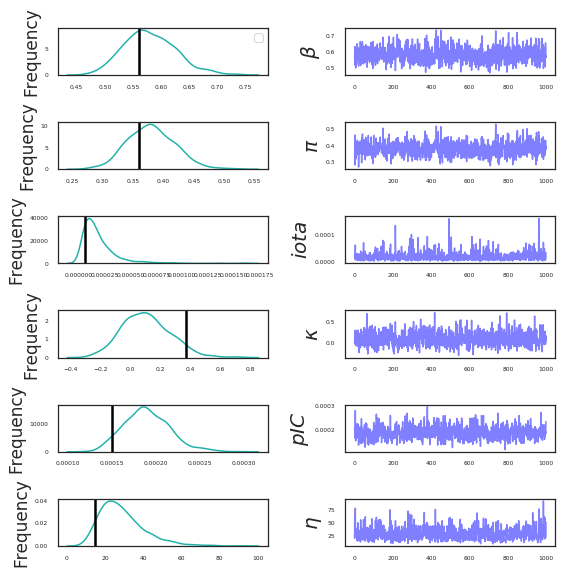

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=3)
sns.set(rc={"figure.figsize":(8,8),"font.size":10,"axes.titlesize":20,"axes.labelsize":17,
           "xtick.labelsize":6, "ytick.labelsize":6},style="white")
param_names = [r"$\beta$", r"$\pi$", r"$iota$", r"$\kappa$", r"$pIC$", r"$\eta$"]#
T_lines = True_params#

for i, p in enumerate(param_names):
        
        # Add histogram subplot
        plt.subplot(6, 2, 1 + 2 * i)
        #plt.xlabel(p)
        plt.ylabel('Frequency')
        sns.kdeplot(params[:, i], color='lightseagreen')
        #sns.kdeplot(py_thinned_trace_rwm[:, i], color='blue', legend=True, label='RWM')

        #plt.axvline(P_lines[i], label='Vanilla MCMC Mean', color='tab:blue')
        #plt.axvline(M_lines[i], label='AMGS Mean', color='tab:red')
        plt.axvline(T_lines[i], linewidth=2.5, color='black')
        if i==0:
                plt.legend()

        # Add trace subplot
        plt.subplot(6, 2, 2 + 2 * i)
        #plt.xlabel('Iteration')
        plt.ylabel(p, fontsize=20)  
        plt.plot(params[:, i], alpha=0.5, color='blue')
        plt.tight_layout()
        #plt.plot(py_thinned_trace_amgs[:, i], alpha=0.5, color='lightseagreen')

In [ ]:
a=fit.get_sampler_params()[0]['divergent__']
a[500:].sum()

In [ ]:
fit.to_dataframe(permuted=False,inc_warmup=False,diagnostics =True)

In [1]:
import scipy.stats as stats
import seaborn as sns
sns.set_context("paper", font_scale=3)
sns.set(rc={"figure.figsize":(12,6),"font.size":10,"axes.titlesize":20,"axes.labelsize":17,
           "xtick.labelsize":8, "ytick.labelsize":8},style="white")
param_names = [r"$\beta$", r"$\pi$", r"$iota$", r"$\kappa$", r"$pIC$", r"$\eta$"]#
l=np.linspace(0,4,1000)
plt.subplot(131)
plt.plot(l,stats.halfnorm(0,1).pdf(l))
plt.axvline(T_lines[0], linewidth=2.5, color='black')
plt.ylabel(param_names[0], fontsize=20)
plt.xlim([0,4])
plt.ylim([0,0.9])
l=np.linspace(0,1,1000)
plt.subplot(132)
plt.plot(l,stats.beta(2,1).pdf(l))
plt.axvline(T_lines[4], linewidth=3.5, color='black')
plt.ylabel(param_names[4], fontsize=20)
plt.xlim([0,1])
plt.ylim([0,3])
l=np.linspace(1,100,1000)
plt.subplot(133)
plt.plot(l,stats.gamma.pdf(l,5,scale=10))
plt.axvline(T_lines[5], linewidth=2.5, color='black')
plt.ylabel(param_names[5], fontsize=20)
plt.xlim([1,100])
plt.ylim([0,0.04])
plt.tight_layout()

NameError: name 'np' is not defined